# Wstęp

Zadanie nr 14 stanowi rozszerzenie wprowadzenia do zagadnienia głębokich modeli uczenia ze wzmocnieniem (*Deep Reinforcement Learning*, **DRL**), w którym omówione zostaną bardziej zaawansowane modele (w szczególności typu *policy gradient* oraz aktor-krytyk).

## Cel ćwiczenia

Celem ćwiczenia jest zapoznanie z:

* metodami *policy gradient* oraz aktor-krytyk w bibliotece *Stable-Baselines3*
* sposobem przygotowywania środowisk dla tego typu modeli
* dostępnymi hiperparametrami i modyfikacjami metod


## Metody *policy gradient*

W odróżnieniu od omawianych poprzednio metod głębokiego uczenia ze wzmocnieniem opartych na funkcjach wartości (gdzie uczymy się ewaluować akcje w dowolnym stanie), w przypadku *policy gradient* próbujemy bezpośrednio ustalić postać strategii optymalnej $\pi^*$. W tym celu stosujemy postać sparametryzowaną $\pi_\theta$, gdzie $\theta$ jest zbiorem parametrów aktualizowanych podczas uczenia:

$$\pi_\theta(\mathbf{s}, \mathbf{a}) = p(\mathbf{a} | \mathbf{s}, \theta)$$

Celem trenowania modelu strategii odbywać się będzie poprzez aktualizowanie parametrów w taki sposób, aby maksymalizować oczekiwaną wartość zwrotu. Uczenie może odbywać się na różne sposoby - w przypadku metod głębokiego uczenia ze wzmocnieniem, model strategii (sieć neuronową) trenować będziemy metodą gradientową.

Funkcja nagrody (której metody *policy gradient* używają jako funkcji celu) będzie zdefiniowana w następujący sposób:

$$\mathcal{L}(\theta) = \sum_{\mathbf{s}\in\mathbf{S}} d^\pi(\mathbf{s})V^\pi(\mathbf{s}) = \sum_{\mathbf{s}\in\mathbf{S}} d^\pi(\mathbf{s})\sum_{\mathbf{a}\in\mathbf{A}}\pi_\theta(\mathbf{a} | \mathbf{s}) Q^\pi(\mathbf{s}, \mathbf{a}),$$

gdzie $d^\pi(\mathbf{s})=\lim_{t\rightarrow\infty}p(\mathbf{s}_t=\mathbf{s}_0, \pi_\theta)$ jest rozkładem stanów *on-policy* przy strategii $\pi$) - prawdopodobieństwo, że w kroku czasowym $t$ uzyskamy stan $\mathbf{s}$ postępując według strategii $\pi_\theta$, $V^\pi(\mathbf{s})$ to funkcja wartości (oczekiwana wartość zwrotu), a $Q^\pi(\mathbf{s}, \mathbf{a})$ to funkcja jakości.

W literaturze występuje wiele metod uczenia  uczenia *policy gradient*. Jednym z aspektów rozróżniajacych je jest sposób obliczania całkowitej wartości zwrotu (w każdym kroku w środowisku, wykorzystując dotychczasową wartość nagród jako estymację funkcji jakości, lub np. przechodząc cały epizod w środowisku).

### Metody aktor-krytyk

Jedną z metod ustalania wartości funkcji jakości jest podejście **aktor-krytyk**. Wykorzystujemy nim dwa modele: **aktor** (model strategii) jest wykorzystywany do podejmowania akcji w środowisku, oraz **krytyk** (model funkcji jakości), służący do estymacji wartości funkcji jakości $Q$.

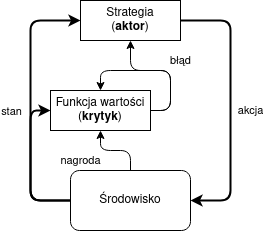

Trenowanie modelu aktor-krytyk polega na uczeniu parametrów $w$ funkcji wartości (krytyka) w celu poprawnego określania wartości zwrotu ($Q$ lub $V$) oraz trenowaniu modelu strategii $\pi_\theta(\mathbf{s}, \mathbf{a})$ (aktora) na podstawie sprzężenia zwrotnego dostarczanego przez krytyka, obserwującego i oceniającego podejmowane akcje. Algorytm dzałania wygląda następująco:

1. Zainicjalizuj stan początkowy $\mathbf{s}_1$, parametry aktora $\theta$ i krytyka $w$
2. Próbkuj akcję $\mathbf{a}_1 \sim \pi_\theta(\mathbf{a} | \mathbf{s})$
3. W każdym kroku czasowym $t = 1, 2, \dots, T$:
  1. Pobierz wartość nagrody $r_t$ i następny stan $\mathbf{s}_{t+1}$
  2. Próbkuj akcję w następnym kroku $\mathbf{a}_{t+1} \sim \pi_\theta(\mathbf{a}_{t+1} | \mathbf{s}_{t+1})$
  3. Zaktualizuj parametry strategii $\theta$ wg gradientu funkcji celu
  4. Zaktualizuj parametry funkcji wartości na podstawie błędu pomiędzy wartością funkcji $Q$ w kolejnym kroku, a sumą funkcji $Q$ z aktualnego oraz uzyskanej nagrody.

Najczęściej używa się dwóch współczynników uczenia: osobno dla trenowania aktora $\alpha_\theta$ oraz krytyka $\alpha_w$.


### A3C/A2C

Algorytmy A3C (*Asynchronous Advantage Actor-Critic*) i A2C (*Advantage Actor-Critic*) [[Mnih et al.](https://arxiv.org/abs/1602.01783)] to dwie wersje metody głębokiego uczenia ze wzmocnieniem oparte na architekturze aktor-krytyk. Metoda ta opiera się na wykorzystaniu wspólnej sieci neuronowej do predykcji akcji (model strategii) oraz ich ewaluacji (model funkcji wartości), przy użyciu odrębnych wyjść (*heads*). Podejście to bazuje na wykorzystaniu wielu agentów, oddziałujących z własną kopią środowiska przy użyciu indywidualnych zestawów wag sieci i uczących swoje kopie przez określony okres, a następnie synchronizujące się z globalną siecią asynchronicznie (A3C) lub synchronicznie (A2C).

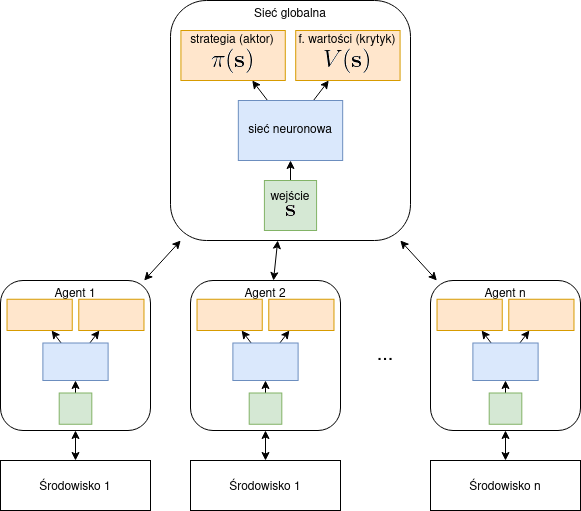

Dzięki zastosowaniu wielu agentów oddziałujących ze swoimi kopiami środowiska, oraz cyklicznemu synchronizowaniu wag z siecią globalną, trenowanie modelu może odbywać się na bardziej zróżnicowanym zbiorze doświadczeń, niż w przypadku pojedynczego agenta, a przez to model powinien zbiegać szybciej, do globalnego optimum bez wykorzystania *experience replay*.

Drugim z ulepszeń zastosowanych w tych metodach jest zastąpienie funkcji jakości $Q$ przez funkcję przewagi $A$. W tym podejściu, model krytyka, zamiast uczyć się wprost wartości funkcji jakości, próbujemy nauczyć się funkcji, która jest różnicą funkcji jakości i funkcji jakości:

$$A(\mathbf{s}, \mathbf{a}) = Q(\mathbf{s}, \mathbf{a}) - V(\mathbf{s})$$

Innymi słowy, chcemy obliczać, o ile lepszy/gorszy będzie wybór akcji $\mathbf{a}$ w stanie $\mathbf{s}$ i postępowanie dalej zgodnie ze strategią od postępowania zgodnie ze strategią bezpośrednio od stanu $\mathbf{s}$.


Podobnie jak poprzednio, skorzystamy z gotowej implementacji metody A3C/A2C z biblioteki [**Stable-Baselines3**](https://stable-baselines.readthedocs.io). Zaczniemy od powtórzenia eksperymentów w środowisku CartPole z poprzedniej listy.


In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay stable-baselines3[extra] > /dev/null 2>&1
!sudo apt-get update
!sudo apt-get install -y python3-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 257 kB in 6s (43.5 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opengl is already the newest version (3.1.5+dfsg-1).
0 upgraded, 0 newly instal

In [2]:
import os
import random

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import animation
from pyvirtualdisplay import Display
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import plot_results, load_results
from stable_baselines3.a2c.policies import MlpPolicy

from IPython import display as ipythondisplay


SEED = 13
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

DISPLAY = Display(visible=0, size=(400, 300))
DISPLAY.start()


def visualize_model(model, max_steps=50, env=None):
    """Show how a model works in the environment."""
    env = env or model.get_env()
    obs = env.reset()

    fig, ax = plt.subplots()
    frames = []
    done = False

    while not done:
        frames.append(env.render(mode="rgb_array"))
        with torch.no_grad():
            action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        if len(frames) >= max_steps:
            break

    anim = animation.FuncAnimation(
        fig=fig,
        func=lambda i: ax.imshow(frames[i]),
        frames=range(len(frames)),
        interval=100,
        blit=False,
    )
    plt.close()

    reward_avg, reward_std = evaluate_policy(model, env, n_eval_episodes=100)
    print(f"Reward in episode: {reward_avg:.2f} +/- {reward_std:.2f}")

    return anim.to_jshtml()


Sprawdźmy, jakie parametry przyjmuje model A2C oraz jego model strategii (zwróćmy uwagę, że stosujemy strategie odpowiednie dla A2C!).

Zwróćmy uwagę, że implementacja A2C w stable-baselines3 przyjmuje jeden współczynnik uczenia `learnin_rate` (stosowany dla modelu strategii) - współczynnik dla funkcji wartości uzyskiwany jest przez przemnożenie przez parametr `vf_coef`. Z kolei interfejs `MlpPolicy` jest podobny do klasy przeznaczonej dla modelu DQN - szczególnie interesująca jest architektura sieci.


In [3]:
help(A2C)


Help on class A2C in module stable_baselines3.a2c.a2c:

class A2C(stable_baselines3.common.on_policy_algorithm.OnPolicyAlgorithm)
 |  A2C(policy: Union[str, Type[stable_baselines3.common.policies.ActorCriticPolicy]], env: Union[gymnasium.core.Env, ForwardRef('VecEnv'), str], learning_rate: Union[float, Callable[[float], float]] = 0.0007, n_steps: int = 5, gamma: float = 0.99, gae_lambda: float = 1.0, ent_coef: float = 0.0, vf_coef: float = 0.5, max_grad_norm: float = 0.5, rms_prop_eps: float = 1e-05, use_rms_prop: bool = True, use_sde: bool = False, sde_sample_freq: int = -1, rollout_buffer_class: Optional[Type[stable_baselines3.common.buffers.RolloutBuffer]] = None, rollout_buffer_kwargs: Optional[Dict[str, Any]] = None, normalize_advantage: bool = False, stats_window_size: int = 100, tensorboard_log: Optional[str] = None, policy_kwargs: Optional[Dict[str, Any]] = None, verbose: int = 0, seed: Optional[int] = None, device: Union[torch.device, str] = 'auto', _init_setup_model: bool = T

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
help(MlpPolicy)


Help on class ActorCriticPolicy in module stable_baselines3.common.policies:

class ActorCriticPolicy(BasePolicy)
 |  ActorCriticPolicy(observation_space: gymnasium.spaces.space.Space, action_space: gymnasium.spaces.space.Space, lr_schedule: Callable[[float], float], net_arch: Union[List[int], Dict[str, List[int]], NoneType] = None, activation_fn: Type[torch.nn.modules.module.Module] = <class 'torch.nn.modules.activation.Tanh'>, ortho_init: bool = True, use_sde: bool = False, log_std_init: float = 0.0, full_std: bool = True, use_expln: bool = False, squash_output: bool = False, features_extractor_class: Type[stable_baselines3.common.torch_layers.BaseFeaturesExtractor] = <class 'stable_baselines3.common.torch_layers.FlattenExtractor'>, features_extractor_kwargs: Optional[Dict[str, Any]] = None, share_features_extractor: bool = True, normalize_images: bool = True, optimizer_class: Type[torch.optim.optimizer.Optimizer] = <class 'torch.optim.adam.Adam'>, optimizer_kwargs: Optional[Dict[str

Zacznijmy od przetestowania niewytrenowanego modelu w środowisku.


In [5]:
env = gym.make("CartPole-v1", render_mode = "rgb_array")
model = A2C(MlpPolicy, env)
display(ipythondisplay.HTML(visualize_model(model)))


Reward in episode: 54.66 +/- 50.22


Analogicznie do zadania 13, spróbujemy wytrenować najprostszy model A2C w celu porównania procesu trenowania i efektów z modelem DQN.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using cpu device
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.7     |
|    ep_rew_mean        | 22.7     |
| time/                 |          |
|    fps                | 396      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.692   |
|    explained_variance | 0.0147   |
|    learning_rate      | 0.0001   |
|    n_updates          | 99       |
|    policy_loss        | 2.1      |
|    value_loss         | 11.1     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 24       |
|    ep_rew_mean        | 24       |
| time/                 |          |
|    fps                | 407      |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps   

Max reward: 173.0


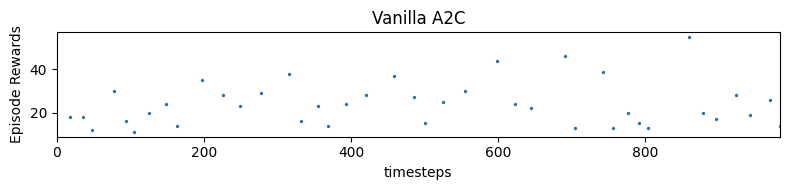

In [6]:
batch_size = 64
lr = 1e-4
total_timesteps = 1000#00

env = gym.make("CartPole-v1", render_mode = "rgb_array")
log_dir = "/tmp/vanilla/"
os.makedirs(log_dir, exist_ok=True)  # we have to create this dir - it does not exist
env = Monitor(env, filename=log_dir)

vanilla_a2c = A2C(
    MlpPolicy, env, learning_rate=lr, seed=SEED,
    verbose=1,
)
vanilla_a2c.learn(total_timesteps)
display(ipythondisplay.HTML(visualize_model(vanilla_a2c)))
plot_results([log_dir], total_timesteps, "timesteps", "Vanilla A2C")
results = load_results(log_dir)
print(f"Max reward: {results.r.max()}")


Wyniki są lepsze niż najprostszy DQN, lecz uczenie trwa stosunkowo długo. Moglibyśmy zająć się teraz strojeniem hiperparametrów, ale zanim to zrobimy, to spróbujmy wykorzystać fakt, że A2C może być stosowany do uczenia modelu przy użyciu wielu agentów na raz. W tym celu będziemy musieli zwektoryzować nasze środowisko - posłuży do tego wbudowana w bibliotekę stable-baselines3 funkcja `make_vec_env`. Sprawdźmy jej parametry.



In [7]:
help(make_vec_env)


Help on function make_vec_env in module stable_baselines3.common.env_util:

make_vec_env(env_id: Union[str, Callable[..., gymnasium.core.Env]], n_envs: int = 1, seed: Optional[int] = None, start_index: int = 0, monitor_dir: Optional[str] = None, wrapper_class: Optional[Callable[[gymnasium.core.Env], gymnasium.core.Env]] = None, env_kwargs: Optional[Dict[str, Any]] = None, vec_env_cls: Optional[Type[Union[stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv, stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv]]] = None, vec_env_kwargs: Optional[Dict[str, Any]] = None, monitor_kwargs: Optional[Dict[str, Any]] = None, wrapper_kwargs: Optional[Dict[str, Any]] = None) -> stable_baselines3.common.vec_env.base_vec_env.VecEnv
    Create a wrapped, monitored ``VecEnv``.
    By default it uses a ``DummyVecEnv`` which is usually faster
    than a ``SubprocVecEnv``.
    
    :param env_id: either the env ID, the env class or a callable returning an env
    :param n_envs: the numbe

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Interesującym dla nas parametrem jest liczba środowisk, które będą wykorzystane w trenowaniu modelu. Ponadto, możemy już tutaj przekazać folder do zapisu historii uczenia `monitor_dir`. Spróbujmy stworzyć 4 środowiska i wytrenować model A2C z użyciem 4 agentów. W stable-baselines3 będze to równie proste, jak dla modelu DQN.

Uwaga: oprócz zwektoryzowanych środowisk tworzymy również osobne środowisko ewaluacyjne, które posłuży nam do sprawdzenia wytrenowanego modelu.


In [8]:
def visualize_model(model, max_steps=50, env=None):
    """Show how a model works in the environment."""
    work_env = env or model.get_env()
    if env:
        obs, _ = work_env.reset()
    else:
        obs = work_env.reset()

    fig, ax = plt.subplots()
    frames = []
    done = False

    while not done:
        frames.append(work_env.render())

        with torch.no_grad():
            action, _ = model.predict(obs)

        if env:
            obs, reward, done, info, _ = work_env.step(action)
        else:
            obs, reward, done, info = work_env.step(action)


        if len(frames) >= max_steps:
            break

    anim = animation.FuncAnimation(
        fig=fig,
        func=lambda i: ax.imshow(frames[i]),
        frames=range(len(frames)),
        interval=100,
        blit=False,
    )
    plt.close()

    reward_avg, reward_std = evaluate_policy(model, work_env, n_eval_episodes=100)
    print(f"Reward in episode: {reward_avg:.2f} +/- {reward_std:.2f}")

    return anim.to_jshtml()

Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.4     |
|    ep_rew_mean        | 22.4     |
| time/                 |          |
|    fps                | 1522     |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 2000     |
| train/                |          |
|    entropy_loss       | -0.693   |
|    explained_variance | 0.0116   |
|    learning_rate      | 0.0001   |
|    n_updates          | 99       |
|    policy_loss        | 2.03     |
|    value_loss         | 10.4     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 23.2     |
|    ep_rew_mean        | 23.2     |
| time/                 |          |
|    fps                | 1502     |
|    iterations         | 200      |
|    time_elapsed       | 2        |
|    total_timesteps    | 4000     |
| train/             

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Reward in episode: 85.17 +/- 30.59


Max reward: 62.0


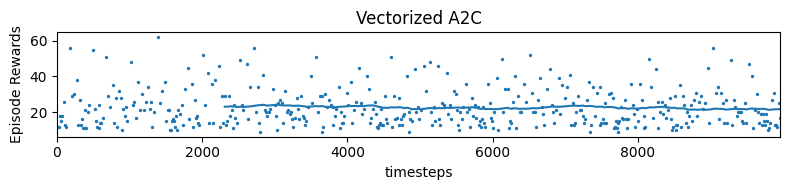

In [9]:
log_dir = "/tmp/vectorized/"
os.makedirs(log_dir, exist_ok=True)  # we have to create this dir - it does not existenv =
eval_env = gym.make("CartPole-v1", render_mode = 'rgb_array')  # evaluation environment
vec_env = make_vec_env("CartPole-v1", n_envs=4, monitor_dir=log_dir)

batch_size = 64
lr = 1e-4
total_timesteps = 10000

vectorized_a2c = A2C(
    MlpPolicy, vec_env, learning_rate=lr, seed=SEED,
    verbose=1,
)
vectorized_a2c.learn(total_timesteps)
display(ipythondisplay.HTML(visualize_model(vectorized_a2c, env=eval_env)))
plot_results([log_dir], total_timesteps, "timesteps", "Vectorized A2C")
results = load_results(log_dir)
print(f"Max reward: {results.r.max()}")


## Zadanie 1.

Zbadaj wpływ kilku (liczba środowisk oraz co najmniej 3 inne) wybranych hiperparametrów na trenowanie i działanie modelu A2C (uwaga: oprócz zbadania należy rozumieć, do czego służy dany hiperparametr). Zapisz swoje wnioski i przygotuj wizualizacje uzyskiwanych rezultatów oraz animiacje działania modelu.


In [10]:
import time

def f_t_str(f: float):
    return str(f).replace(".", "_")


def get_log_dir(
    env_name:str,
    gamma: float,
    n_steps: int,
    gae_lambda: float,
    agents:int,
    ent_coef: float,
):
    return f"/tmp/vectorized/{env_name}/gamma_{f_t_str(gamma)}/n_steps_{n_steps}/gae_lambda_{f_t_str(gae_lambda)}/agents_{agents}/ent_coef_{ent_coef}"


def test(
    env_name:str,
    gamma: float = 0.99,
    n_steps: int = 5,
    gae_lambda: float = 1.0,
    agents:int = 4,
    total_timesteps: int = 50_000,
    show_res: bool = False,
    ent_coef: float = 0,
):
    log_dir = get_log_dir(env_name, gamma, n_steps, gae_lambda, agents, ent_coef)
    os.makedirs(log_dir, exist_ok=True)
    eval_env = gym.make(env_name, render_mode = 'rgb_array')
    vec_env = make_vec_env(env_name, n_envs=agents, monitor_dir=log_dir)

    lr = 1e-4

    vectorized_a2c = A2C(
        MlpPolicy,
        vec_env,
        learning_rate=lr,
        seed=SEED,
        gamma=gamma,
        n_steps=n_steps,
        gae_lambda=gae_lambda,
        ent_coef=ent_coef,
        verbose=0,
    )

    start_time = time.time()
    vectorized_a2c.learn(total_timesteps)
    end_time = time.time()

    results = load_results(log_dir)

    performance_metrics = {
        "log_dir": log_dir,
        "total_timesteps": total_timesteps,
        "max_reward": results.r.max(),
        "mean_reward": results.r.mean(),
        "median_reward": results.r.median(),
        "final_reward": results.r.iloc[-1],
        "reward_std": results.r.std(),
        "learning_time": end_time - start_time,
        "gamma": gamma,
        "n_steps": n_steps,
        "gae_lambda": gae_lambda,
        "agents": agents,
        "ent_coef": ent_coef,
    }

    if show_res:
        display(ipythondisplay.HTML(visualize_model(vectorized_a2c, env=eval_env)))
        plot_results([log_dir], total_timesteps, "timesteps", "Vectorized A2C")
        print(f"Max reward: {results.r.max()}")

    return performance_metrics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
import time
import itertools
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


def get_average_for_param(result: pd.DataFrame, param: str, score: str = "max_reward") -> pd.DataFrame:
    avg_scores = result.groupby(param)[score].mean()
    avg_scores_df = avg_scores.reset_index()
    avg_scores_df.columns = [param, score]
    return avg_scores_df

def plot_avg_scores(result: pd.DataFrame, param: str, score: str = "max_reward", ax: plt.Axes = None):
    avg_scores = get_average_for_param(result, param, score)
    avg_learning_time = get_average_for_param(result, param, "learning_time")

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    color = 'tab:green'
    ax.set_xlabel(param.capitalize())
    ax.set_ylabel(score, color=color)
    ax.plot(avg_scores[param], avg_scores[score], color=color)
    ax.scatter(avg_scores[param], avg_scores[score], color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.legend([score], loc='upper left')

    ax2 = ax.twinx()
    color = 'tab:red'
    ax2.set_ylabel("Learning Time", color=color)
    ax2.plot(avg_learning_time[param], avg_learning_time["learning_time"], color=color)
    ax2.scatter(avg_learning_time[param], avg_learning_time["learning_time"], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(["Learning Time"], loc='upper right')

    ax.yaxis.set_major_formatter('{x:.2f}')
    ax2.yaxis.set_major_formatter('{x:.2f} s')

    if ax is None:
        fig.tight_layout()
        plt.title(f"{score} and Learning Time for Different {param.capitalize()} Values per Dataset")
        plt.show()


def plot_all_avg_scores(result: pd.DataFrame, params: list[str], score: str = "max_reward"):
    num_plots = len(params)
    num_cols = num_plots
    num_rows = 1

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 6))
    axs = axs.flatten()

    for i, param in enumerate(params):
        ax = axs[i]
        plot_avg_scores(result, param, score, ax=ax)

    if num_plots < num_cols:
        for ax in axs[num_plots:]:
            ax.axis('off')

    fig.tight_layout()
    plt.show()

In [12]:
gammas = [0.9, 0.95, 0.99]
n_steps = [4, 5, 6]
gae_lambdas = [0.9, 0.95, 1.00]
agents = [5, 7, 10]

params = list(itertools.product(gammas, n_steps, gae_lambdas, agents))

cart_results_df = []
for i in tqdm(range(len(params)), total=len(params)):
    gamma, n_step, gae_lambda, agent = params[i]
    result = test("CartPole-v1", gamma, n_step, gae_lambda, agent)
    cart_results_df.append(result)

cart_results_df = pd.DataFrame(cart_results_df)

  0%|          | 0/81 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


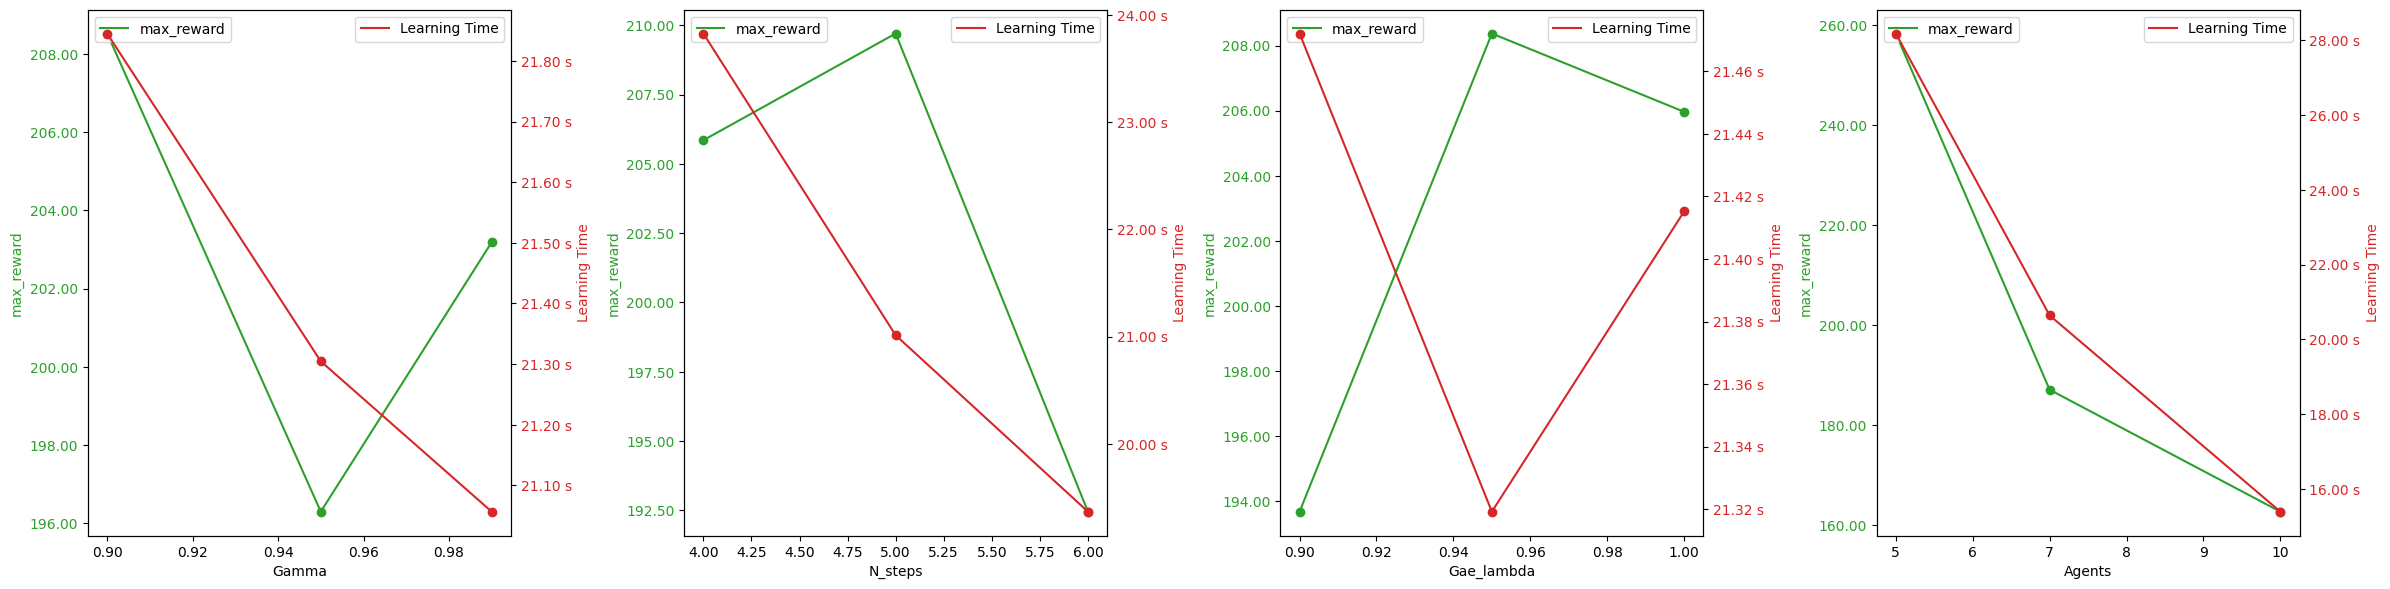

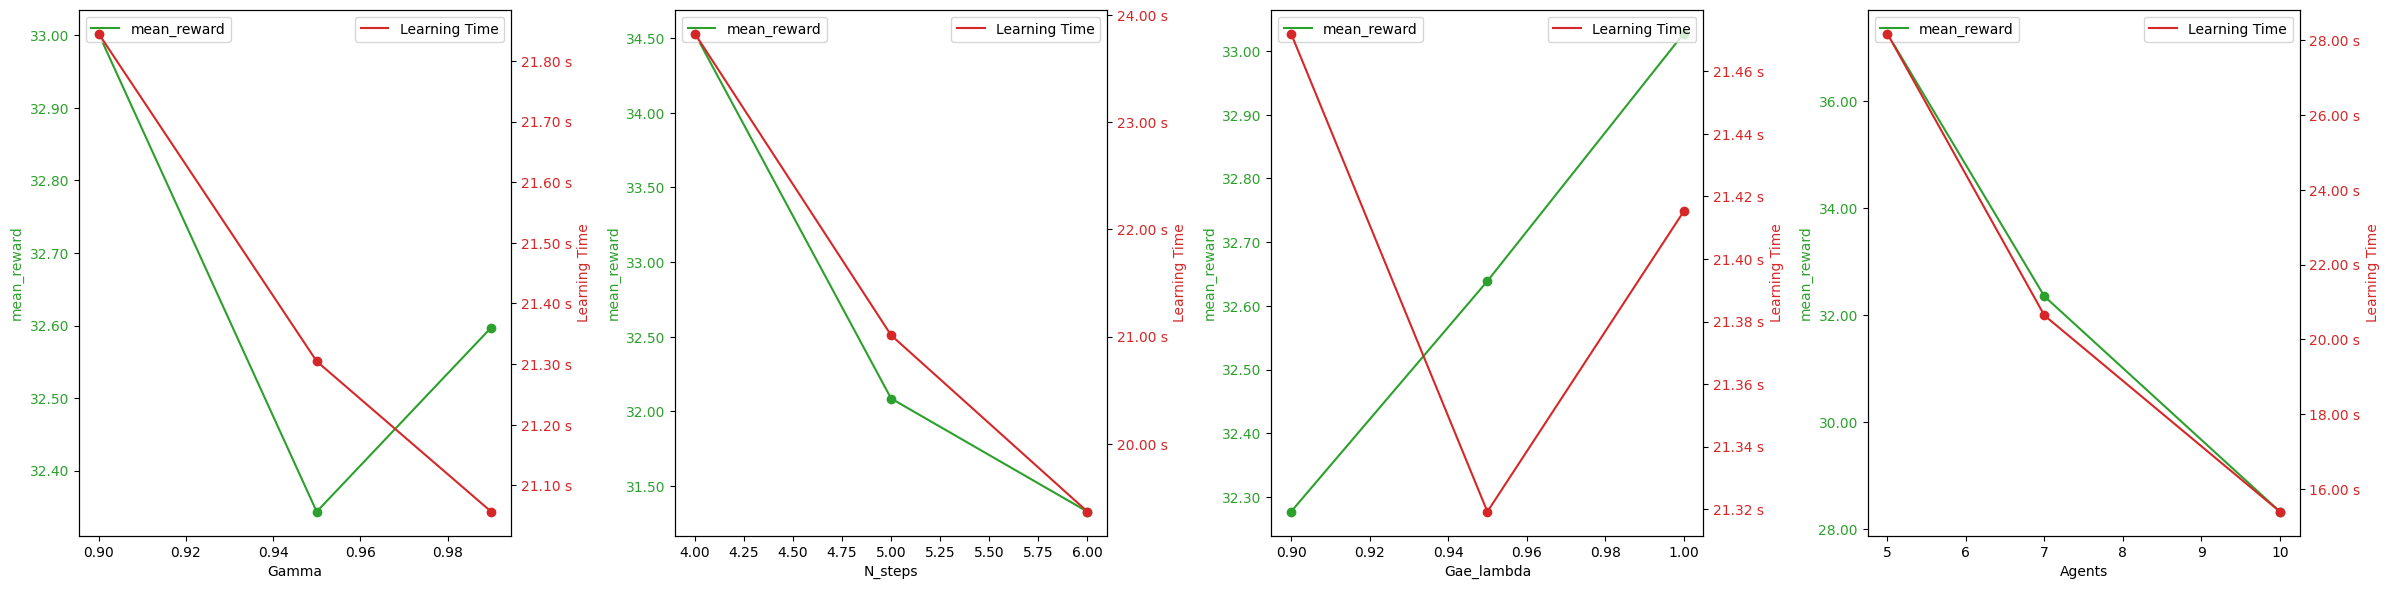

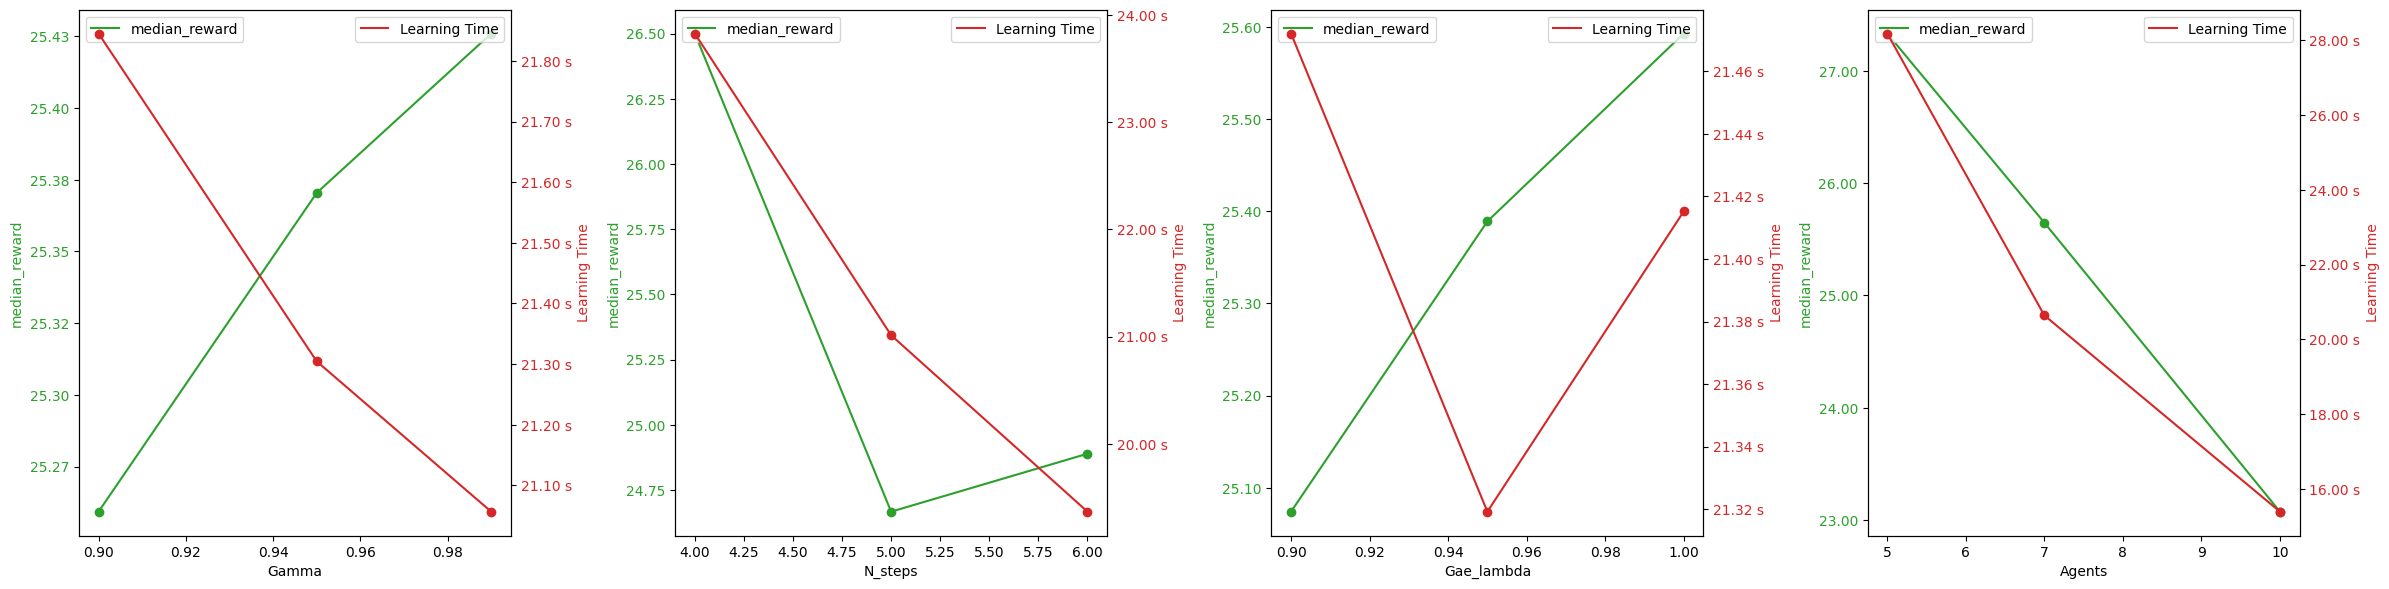

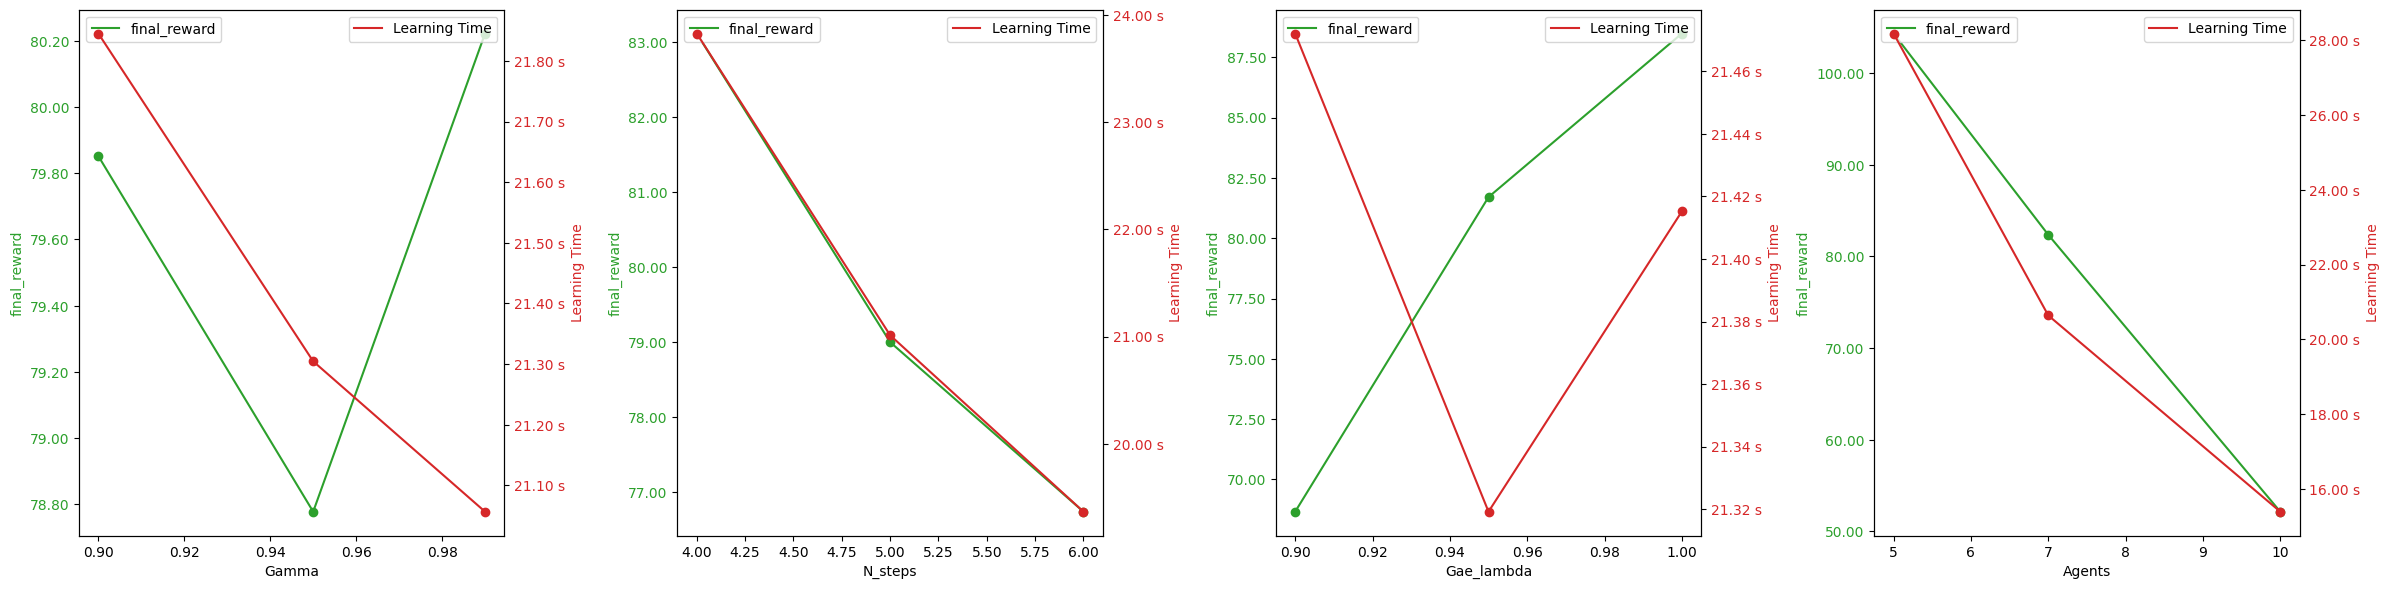

In [13]:

plot_all_avg_scores(cart_results_df, ["gamma", "n_steps", "gae_lambda", "agents"], "max_reward")
plot_all_avg_scores(cart_results_df, ["gamma", "n_steps", "gae_lambda", "agents"], "mean_reward")
plot_all_avg_scores(cart_results_df, ["gamma", "n_steps", "gae_lambda", "agents"], "median_reward")
plot_all_avg_scores(cart_results_df, ["gamma", "n_steps", "gae_lambda", "agents"], "final_reward")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                              log_dir  total_timesteps  \
75  /tmp/vectorized/CartPole-v1/gamma_0_99/n_steps...            50000   

    max_reward  mean_reward  median_reward  final_reward  reward_std  \
75       324.0    33.722598           26.0          22.0    25.20747   

    learning_time  gamma  n_steps  gae_lambda  agents  ent_coef  
75      25.257127   0.99        6        0.95       5         0  


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Reward in episode: 500.00 +/- 0.00


Max reward: 500.0


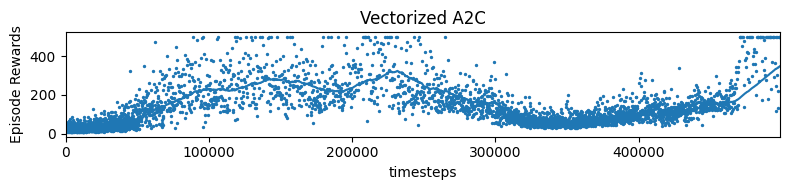

In [14]:
top_params = cart_results_df.sort_values(by="max_reward", ascending=False).head(1)
print(top_params)
best_gamma, best_n_step, best_gae_lambda, best_agent = top_params['gamma'].iloc[0], top_params['n_steps'].iloc[0], top_params['gae_lambda'].iloc[0], top_params['agents'].iloc[0]
top = test("CartPole-v1", best_gamma, best_n_step, best_gae_lambda, best_agent, total_timesteps= 500_000,show_res = True)


## Zadanie 2.

Jedną z zalet metod *policy gradient* oraz aktor-krytyk jest fakt, że dzięki zastosowaniu modelu strategii możliwe jest działanie modelu w środowiskach z ciągłą przestrzenią akcji. Wybierz dowolne środowisko z ciągłą przestrzenią akcji spośród dostępnych w bibliotece [Gym](https://gym.openai.com/envs) i zastosuj na nim model A2C. Dostrój hiperparametry modelu tak, aby uzyskać poprawne działanie. Zapoznaj się z definicją funkcji nagrody w środowisku.

W przypadku wyboru środowiska z obserwacjami wizualnymi zmodyfikuj wykorzystany model strategii. (Uwaga: proszę mieć na uwadze, że trenowanie modeli A2C dla środowisk o ciągłej przestrzeni akcji jest bardziej złożone obliczeniowo - próba wytrenowania modelu dla bardzo złożonego środowiska może zająć dłużej).


In [15]:
gammas = [0.9, 0.95, 0.99]
n_steps = [4, 5, 6]
gae_lambdas = [0.9, 0.95, 1.00]
agents = [5, 7, 10]

params = list(itertools.product(gammas, n_steps,gae_lambdas, agents))

pendulum_results_df = []
for i in tqdm(range(len(params)), total=len(params)):
    gamma, n_step, gae_lambdas , agent = params[i]
    result = test("Pendulum-v1", gamma, n_step, gae_lambdas , agent)
    pendulum_results_df.append(result)
    pd.DataFrame(pendulum_results_df).to_csv(f"car_results_checkpoint_{i}.csv")

pendulum_results_df = pd.DataFrame(pendulum_results_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/81 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                              log_dir  total_timesteps  \
26  /tmp/vectorized/Pendulum-v1/gamma_0_9/n_steps_...            50000   

    max_reward  mean_reward  median_reward  final_reward  reward_std  \
26 -623.081623  -1237.06037   -1208.826153  -1438.051483  294.858602   

    learning_time  gamma  n_steps  gae_lambda  agents  ent_coef  
26      14.316149    0.9        6         1.0      10         0  


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Reward in episode: -1799.44 +/- 116.09


Max reward: -623.081623


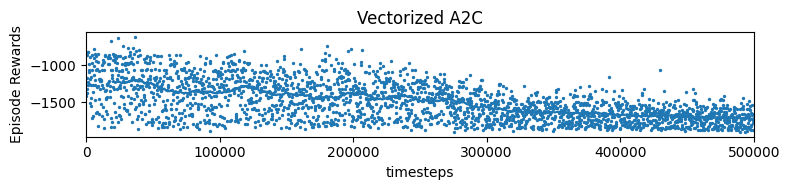

In [16]:
top_params = pendulum_results_df.sort_values(by="max_reward", ascending=False).head(1)
print(top_params)
best_gamma, best_n_step, best_gae_lambda, best_agent = top_params['gamma'].iloc[0], top_params['n_steps'].iloc[0], top_params['gae_lambda'].iloc[0], top_params['agents'].iloc[0]
top = test("Pendulum-v1", best_gamma, best_n_step, best_gae_lambda, best_agent, total_timesteps= 500_000,show_res = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


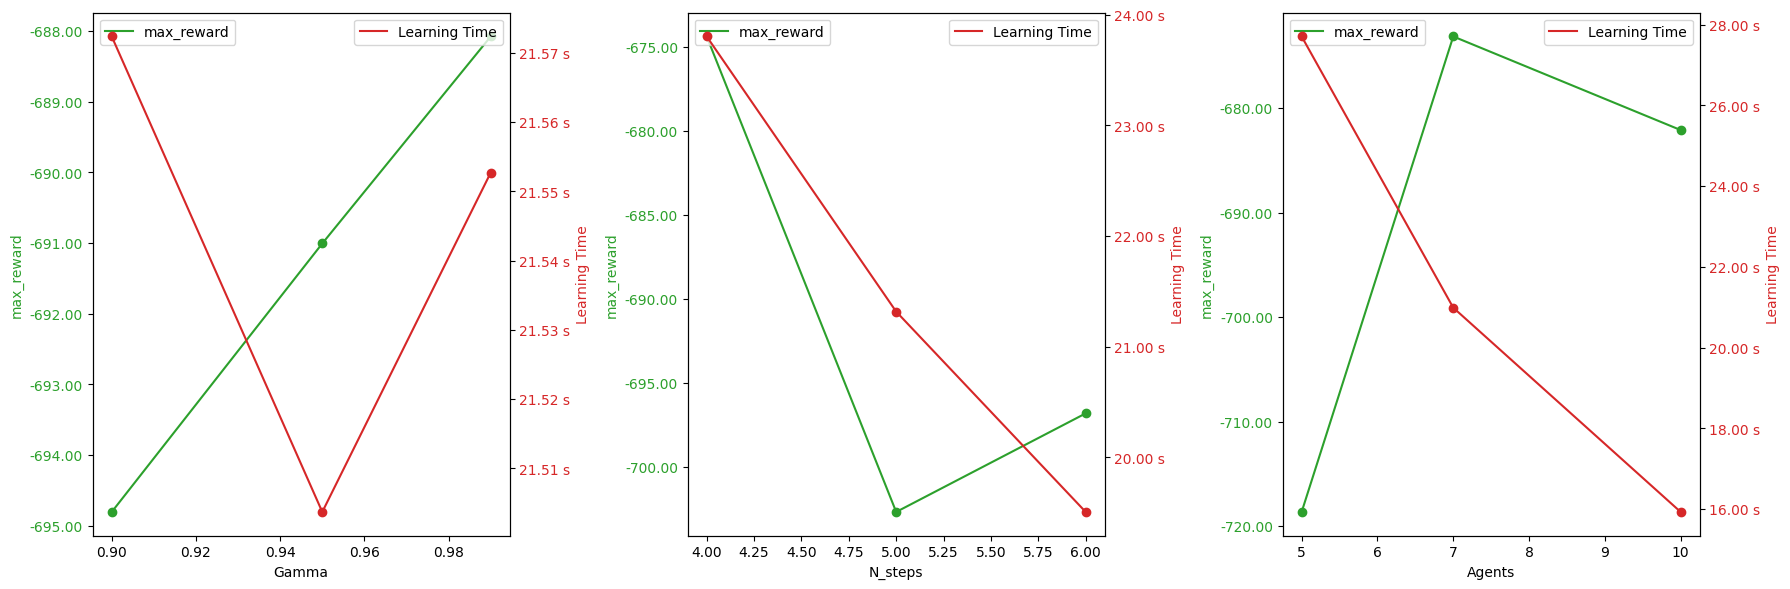

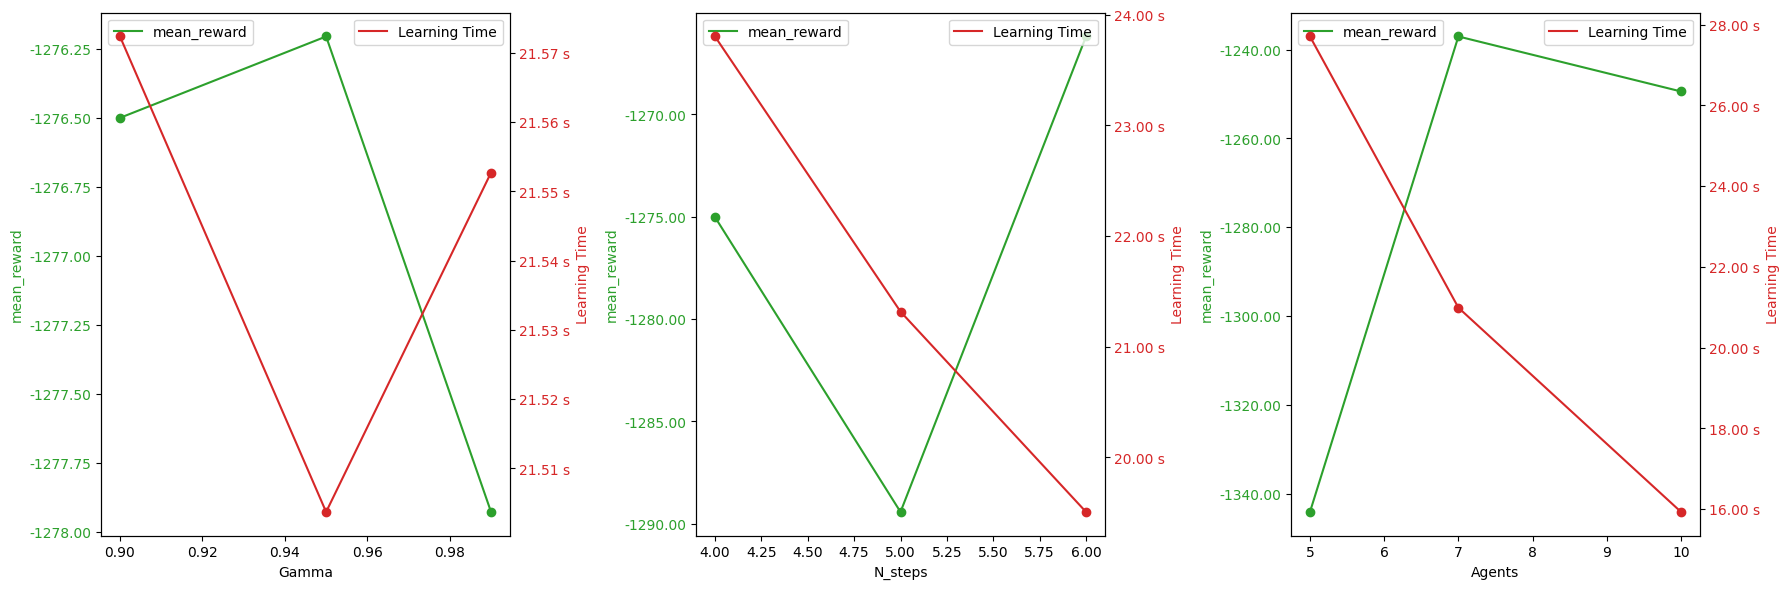

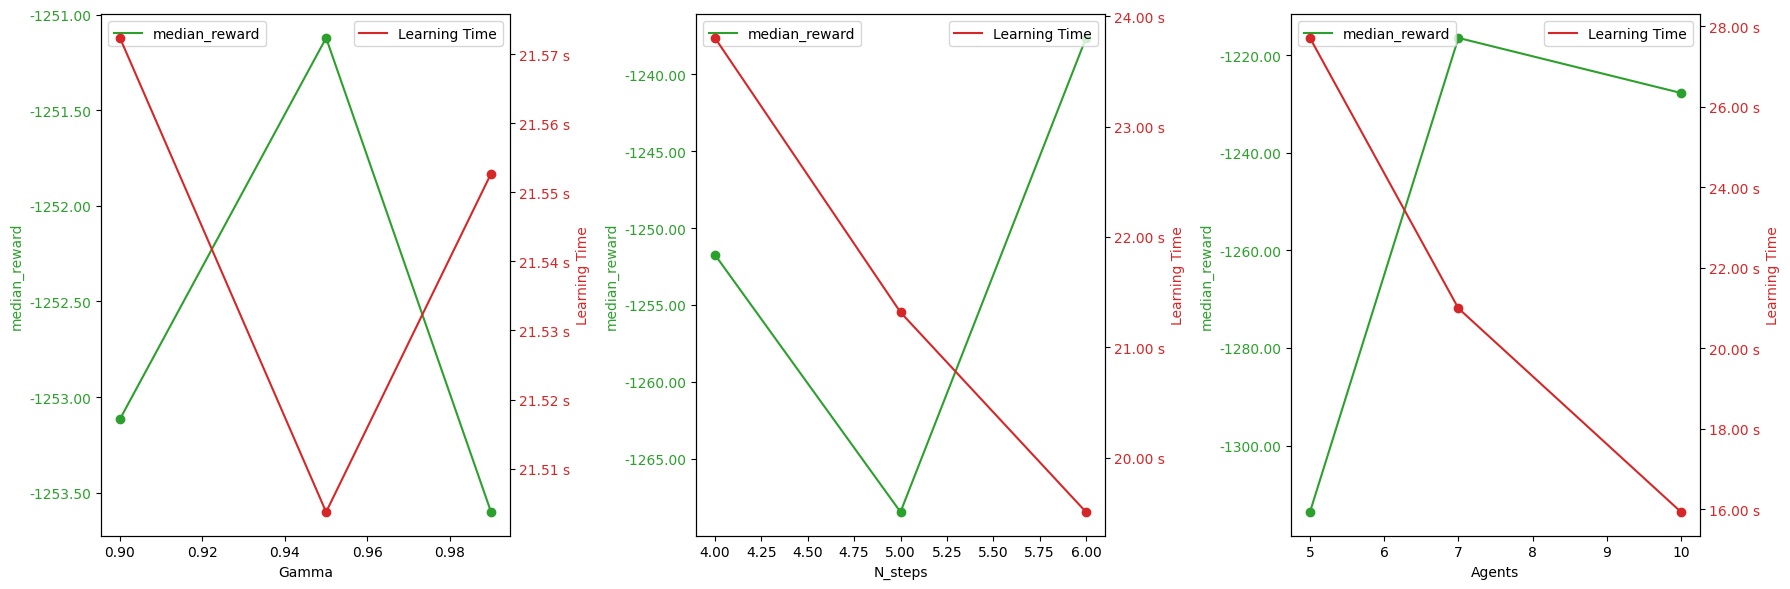

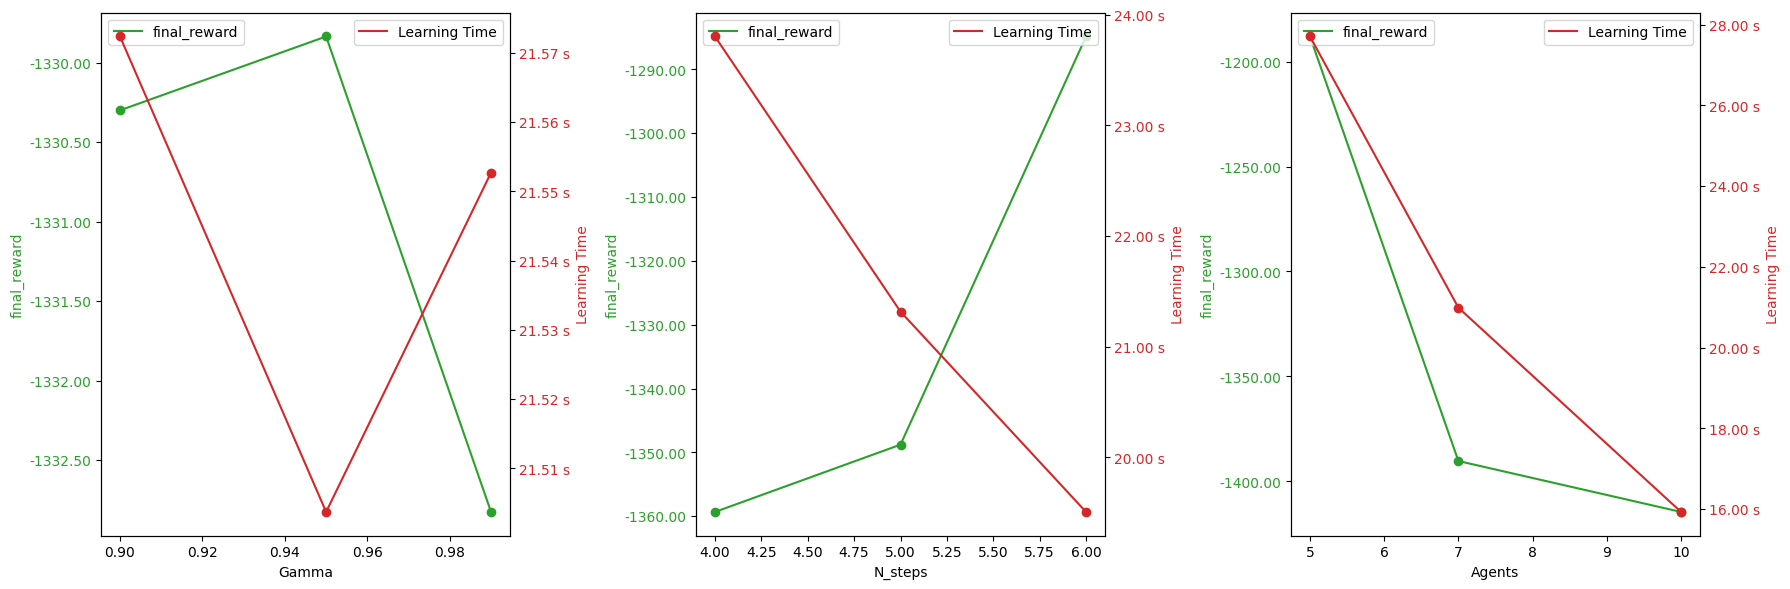

In [17]:
plot_all_avg_scores(pendulum_results_df, ["gamma", "n_steps", "agents"], "max_reward")
plot_all_avg_scores(pendulum_results_df, ["gamma", "n_steps", "agents"], "mean_reward")
plot_all_avg_scores(pendulum_results_df, ["gamma", "n_steps", "agents"], "median_reward")
plot_all_avg_scores(pendulum_results_df, ["gamma", "n_steps", "agents"], "final_reward")